<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/firststepAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init

In [0]:
batch_size = 32
learning_rate = 0.0002
num_epoch = 5

In [3]:
mnist_train = datasets.MNIST("./", train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]), download=True)
mnist_test = datasets.MNIST("./", train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]), download=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [0]:
# 인공신경망으로 이루어진 오토엔코더를 생성합니다.
# 단순하게 하기 위해 활성화 함수는 생략했습니다.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Linear(28*28,20)
        self.decoder = nn.Linear(20,28*28)   
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [0]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        
    if j % 1000 == 0:
        print(loss)
        loss_arr.append(loss.cpu().data.numpy()[0])

torch.Size([32, 28, 28])


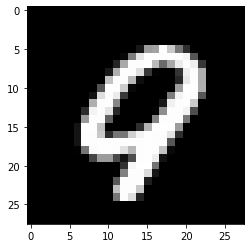

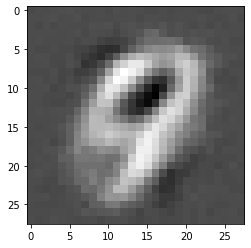

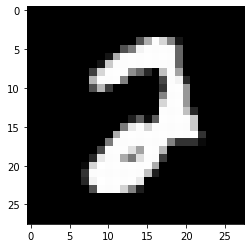

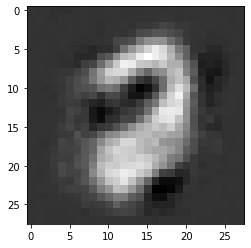

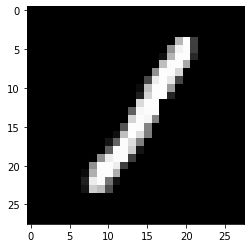

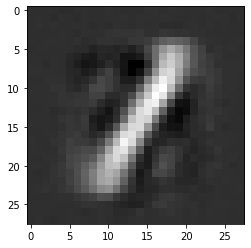

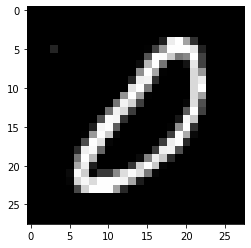

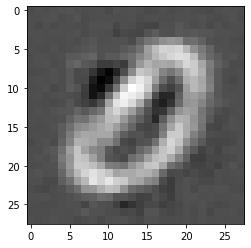

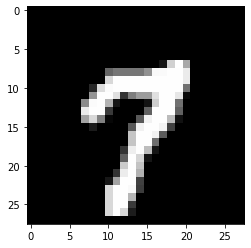

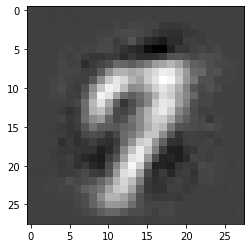

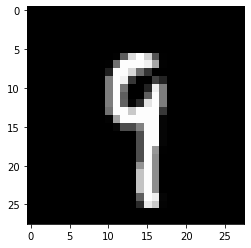

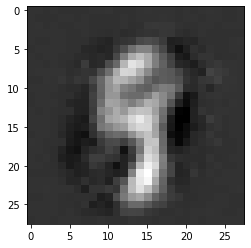

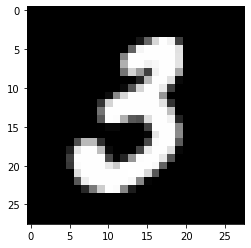

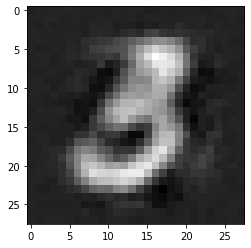

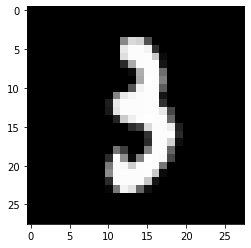

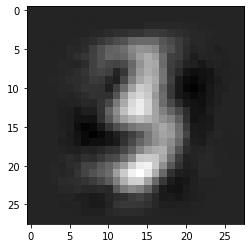

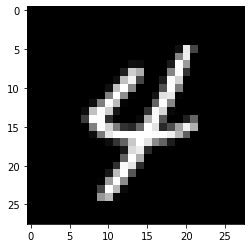

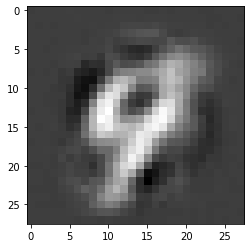

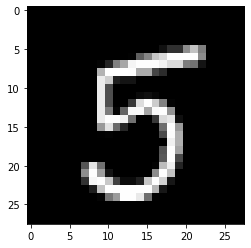

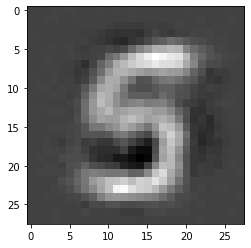

In [8]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [0]:
with torch.no_grad():
  for i in range(1):
      for j,[image,label] in enumerate(test_loader):
          x = image.to(device)

          optimizer.zero_grad()
          output = model.forward(x)

      if j % 1000 == 0:
          print(loss)        

torch.Size([32, 28, 28])


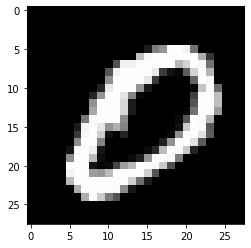

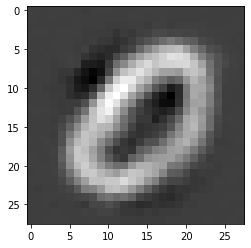

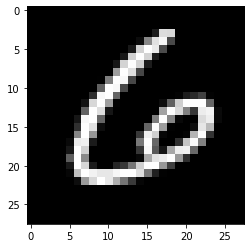

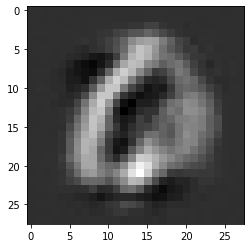

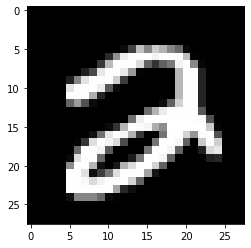

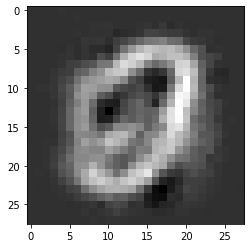

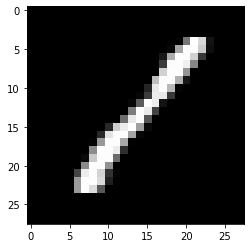

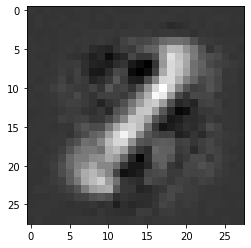

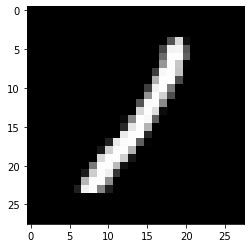

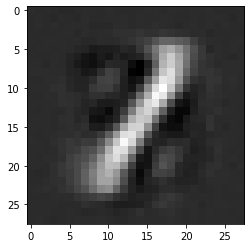

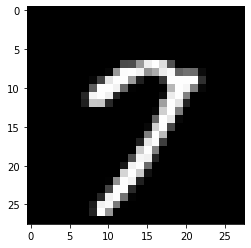

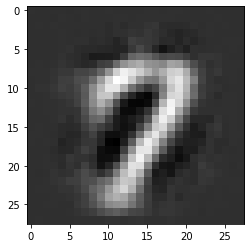

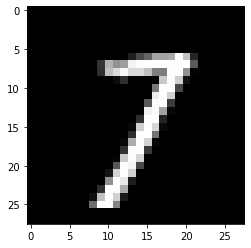

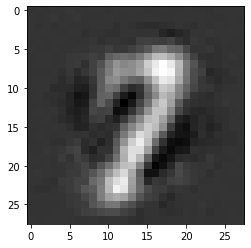

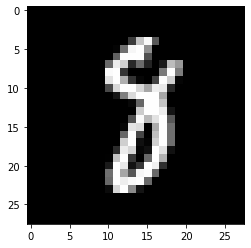

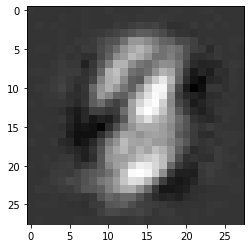

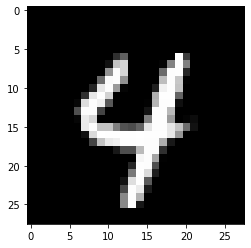

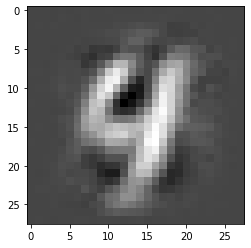

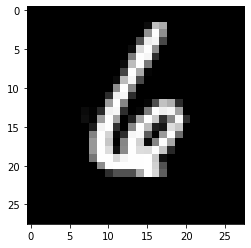

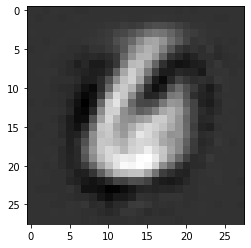

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),                            # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 7 x 7
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(batch_size, -1)
        return out

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,2,1,1),                    # batch x 32 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),                      # batch x 1 x 28 x 28
                        nn.ReLU(),
        )
        
    def forward(self,x):
        out = x.view(batch_size,64,7,7)
        out = self.layer1(out)
        return out

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [14]:
from torchsummary import summary
summary(encoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6           [-1, 64, 14, 14]               0
       BatchNorm2d-7           [-1, 64, 14, 14]             128
         MaxPool2d-8             [-1, 64, 7, 7]               0
Total params: 19,008
Trainable params: 19,008
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.93
Params size (MB): 0.07
Estimated Total Size (MB): 1.01
----------------------------------------------------------------


In [15]:
summary(decoder, (64,7,7)) # 오류로 인해 확인 불가

RuntimeError: ignored

In [16]:
print(encoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [17]:
print(decoder)

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
  )
)


In [18]:
# 모델을 불러오는 방법입니다.
# 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        # 모델 저장하는 방법
        # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
        print(loss)



--------model not restored--------



torch.Size([32, 28, 28])


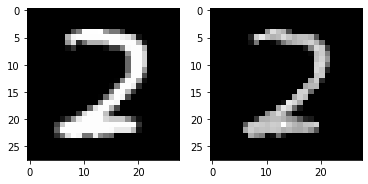

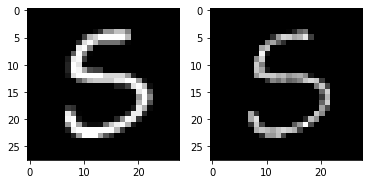

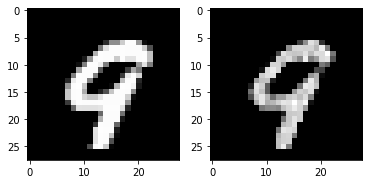

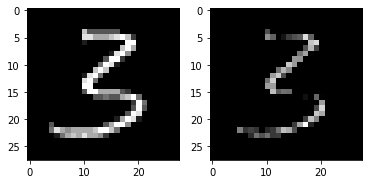

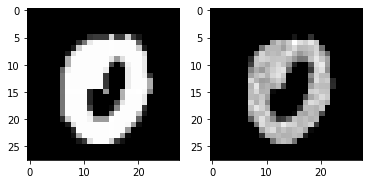

In [19]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [0]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([32, 28, 28])


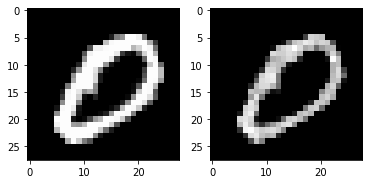

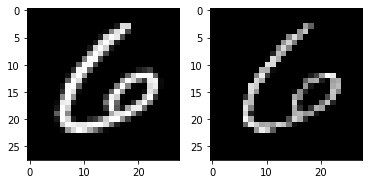

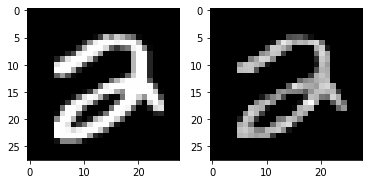

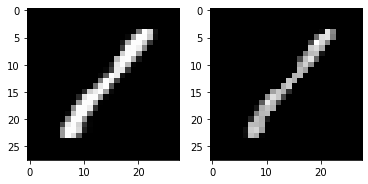

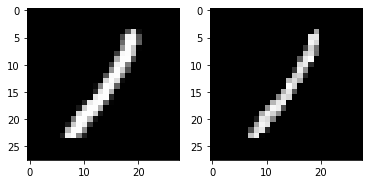

In [21]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [29]:
# 오염된 이미지 복원

try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

def add_noise(image):
  noise = torch.randn(image.size()) * 0.2
  noisy_image = image + noise
  return noisy_image

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = add_noise(image)
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
        print(loss)



--------model not restored--------



torch.Size([32, 28, 28])


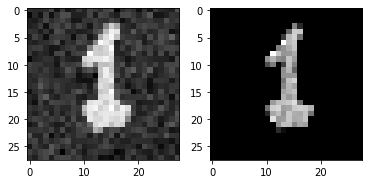

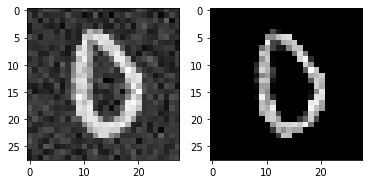

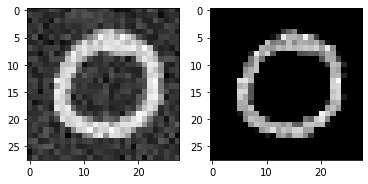

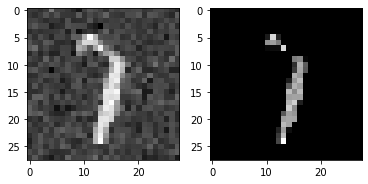

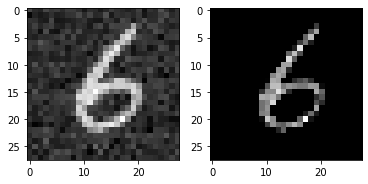

In [30]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()